## Figure 9 - Scaleing pool area and $\Phi_{Tr}$

### Pool scaling

Tracer flux into the pool from canyon upwelling:
$\Phi_{Tr}\propto \Phi \Delta C \propto U\mathcal{F}W_mZ^2\delta_zC$,

where $\Delta C=Z\delta_zC$ is the "extra" concentration coming up onto the shelf compared to a vertcally homogeneous tracer.

If there was no canyon upwelling and the pool was just made up of shelf water and generated by Ekman transport through the bottom boundary layer on the shelf, that is shut down due to the balance of buoyancy forces acting against Coriolis force generating Ekman transport (MacCready and Rhines 1993, Slippery Bottom Boundary Layers), that BBL would have a length across the shelf given by

$\mathcal{L}=\frac{fU}{(N\theta)^2}$ (This can be derived from thermal wind equations, (MacCready and Rhines, 1993))

A correponding vertical scale - which in fact is the thickness of the BBL but that cannot be assured for upwelling case - is given by

$\mathcal{H}=\mathcal{L}sin{\theta} \approx \mathcal{L}\theta$ since $\theta<<1$.

So, a volume for a pool made up of shelf water (background water) can be constructed as

$V_{bg}= A_{pool}\mathcal{H}$.

Assuimig shutdowns has occured, a timescale would be 

$\tau_0\approx \frac{f}{(N\theta)^2}$ (MacCready and Rhines, 1993). There is a better, more complicated approximation for this but I don't think that is necessary.

Then , the flux of tracer associated to the background pool would be

$\Phi_{bg}\approx \frac{Apool\mathcal{H}}{\tau_0} (H_s-H_h)\delta_zC_{bg})$,

Where $(H_s-H_h)\delta_zC_{bg}$ is analogous to $\Delta C$ and represents the background concentration on the shelf within the shelf pool.

Assuming both tracer fluxes, $\Phi_{Tr}$ and $\Phi_{bg}$, are of the same order, the area of the pool is proportional to

$A_{pool}\propto \frac{U\mathcal{F}W_mZ^2\delta_zC\tau_0}{\mathcal{H}(H_s-H_h)\delta_zC_{bg}}$

Substituting the expresions for $\mathcal{H}$ and $\tau_0$

$A_{pool}\propto \frac{\mathcal{F}W_mZ^2\delta_zC}{\theta(H_s-H_h)\delta_zC_{bg}}$.

Further, we know that the slope $s=(H_s-H_h)/L$ and angle $\theta$ are related as $\theta\sim s$. Substituting the value of s

$A_{pool}\propto \frac{W_mL\mathcal{F}Z^2\delta_zC}{(H_s-H_h)^2\delta_zC_{bg}}$.

Approximating the canyon area as a triangle of base $W_m$ and height $L$, its area would be 

$A_{can}=\frac{W_mL}{2}$.

Substituting $A_{can}$ in the expression for $A_{pool}$ we get

$A_{pool}\propto \frac{2 A_{can}\mathcal{F}Z^2\delta_zC}{(H_s-H_h)^2\delta_zC_{bg}}$.

This is nice because the pool area is a function of the canyon area and a non-dimensional number that represents the competiton between the tracer that comes up onto the shelf due to the canyon and due to the gradient of the tracer below the shelf, and the background tracer that would be on the pool.


In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [4]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','DS 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,\
    sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                            [sb_conc_A, sb_conc_B],
                            [sb_Ast, sb_Bar],
                            [drC_A, drC_B],
                            [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = (1E-3*nbl.variables[trac][0,:,10,180])/1E-3 # nM to mu mol/m^3
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*profile.data/1000)/1E-3 # mumol/kg mu mol/m^3
                
            else:
                tr_profile = (nbl.variables[trac][0,:,10,180])/1E-3 # muM to mu mol/m^1
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            sb_array[ii] = tr_profile[sb_ind]

In [5]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

head_zind = [19,19,34,34]
Z_zind = [30,20,14,21]
g = 9.81
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBar = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileAst = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
ptr_filePath = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/ptracersGlob.nc'
ptr_fileArgo = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/ptracersGlob.nc'

state_fileArgo = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc'
stateArgo = xr.open_dataset(state_fileArgo)
state_filePath = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc'
statePath = xr.open_dataset(state_filePath)
        
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','DS 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_gradZ_Ast = np.empty(len(labels))
sb_gradZ_Argo = np.empty(len(labels))
sb_gradZ_Bar = np.empty(len(labels))
sb_gradZ_Path = np.empty(len(labels))
sb_gradtop_Ast = np.empty(len(labels))
sb_gradtop_Argo = np.empty(len(labels))
sb_gradtop_Bar = np.empty(len(labels))
sb_gradtop_Path = np.empty(len(labels))
N_top_Ast = np.empty(len(labels))
N_top_Argo = np.empty(len(labels))
N_top_Bar = np.empty(len(labels))
N_top_Path = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_ind,head_ind,Z_ind,grad_array,gradtop_array,drc,state,Ntop \
    in zip([ptr_fileAst,ptr_fileArgo,ptr_fileBar,ptr_filePath],
            [sb_Ast,sb_Ast,sb_Bar, sb_Bar],
            head_zind,
            Z_zind,
            [sb_gradZ_Ast,sb_gradZ_Argo,sb_gradZ_Bar,sb_gradZ_Path],
            [sb_gradtop_Ast,sb_gradtop_Argo,sb_gradtop_Bar,sb_gradtop_Path],
            [drC_A, drC_A, drC_B, drC_B],
            [stateA,stateArgo,stateB,statePath],
            [N_top_Ast,N_top_Argo,N_top_Bar,N_top_Path],):
        
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = (1E-3*nbl.variables[trac][0,:,10,180])/1E-3 # nM to mu mol/m^3
                density = call_rho(0,state,slice(0,104),180,20)
                
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*profile.data/1000)/1E-3 # muM to mu mol/m^3 
                
            else:
                tr_profile = nbl.variables[trac][0,:,10,180]/1E-3 # muM to mu mol/m^3
                density = call_rho(0,state,slice(0,104),180,20)
                
            Ntop[ii] = np.nanmean((-(g/RhoRef)* \
                                ((density.data[head_ind-2:sb_ind-2]-
                                  density.data[head_ind:sb_ind])/ \
                                 (drc[head_ind-2:sb_ind-2] + 
                                  drc[head_ind:sb_ind])))**0.5)
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            
            grad_array[ii] = np.nanmean(tr_grad[head_ind:head_ind+Z_ind]) 
            gradtop_array[ii] = np.nanmean(tr_grad[sb_ind-10:sb_ind])

In [6]:
print(N_top_Ast[0])
print(N_top_Argo[0])
print(N_top_Bar[0])
print(N_top_Path[0])

0.005496364974364435
0.010637455328840932
0.0054964002988617125
0.005062776950206889


### Scaling pool and $\Phi_{Tr}$

In [7]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)

g = 9.81 # accel. gravity
s = np.array([0.00230,0.00230,0.00454,0.00454]) # shelf slope 
N = np.array([0.0055,0.0088,0.0055,0.0038]) # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4,1.0E-4,1.08E-4])
U = np.array([0.3,0.329,0.3,0.288])
Wiso = np.array([8900,8900,8300,8300])
Wsbs = np.array([15700,15700,13000,13000])
R = np.array([4500,4500,5000,5000])
L = np.array([21800,21800,6400,6400])
Hhs = [97.5,97.5,172.5,172.5]
Hss = [150,150,200,200]

MAX POOL AREA: slope = 8.57e+00, intercept = -443681850.430, r-value = 0.940, std_err = 5.033e-01


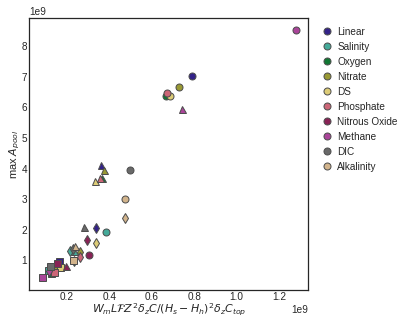

In [8]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax0=plt.subplots(1,1,figsize=(5,5))

labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS',
              'Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677',
           '#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01',
        'UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]
N_top = [N_top_Ast, N_top_Argo, N_top_Bar, N_top_Path]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad,gradtop,Ntop,conc,Hh,Hs,ff,nn,uu,ll,ww,wsb,ss, rr, mark in zip(exp_files, 
                                                                        runs,runs_phi,
                                                                        labels_exp,
                                                                        can_Area,exps,
                                                                        sb_grad,
                                                                        sb_gradtop,
                                                                        N_top,
                                                                        sb_conc,Hhs,Hss,
                                                                        f,N,U,L,Wiso,
                                                                        Wsbs,s,R,
                                                                        markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        slope = (Hs-Hh)/ll
        Cs = conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,ww))
        theta = np.arctan(slope)
        T = ff/((nn**2)*(theta**2))# 
        Hpool = (ff*uu)/((nn**2)*(theta))
        PhidC = uu*(ZZ**2)*calF*Wsb*grad[ii]
        Cbg = (Hs-Hh)*gradtop[ii]
        Pi = (calF*(ZZ**2)*grad[ii])/(((Hs-Hh)**2)*gradtop[ii])
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(Pi*(Wsb*ll),#(PhidC*T)/(Cbg*Hpool),
                             np.nanmax(area[ii,:]),
                             'o', mfc = col, mec='0.3',mew=1, 
                             label = tr_lab)
                    Pi_array[kk]=Pi*(Wsb*ll)#(PhidC*T)/(Cbg*Hpool)
                    area_array[kk]=np.nanmax(area[ii,:])
                else:
                    ax0.plot(Pi*(Wsb*ll),
                             np.nanmax(area[ii,:]),
                              '^', mfc = col, mec='0.3',mew=1) 
                    Pi_array[kk]=Pi*(Wsb*ll)
                    area_array[kk]=np.nanmax(area[ii,:])
            else:
                if lab_exp=='BAR':
                    ax0.plot(Pi*(Wsb*ll),
                             np.nanmax(area[ii,:]),
                             's', mfc = col, mec='0.3',mew=1)
                    Pi_array[kk]=Pi*(Wsb*ll)
                    area_array[kk]=np.nanmax(area[ii,:])
                else:
                    ax0.plot(Pi*(Wsb*ll),
                             np.nanmax(area[ii,:]),
                            'd', mfc = col, mec='0.3',mew=1)
                    Pi_array[kk]=Pi*(Wsb*ll)
                    area_array[kk]=np.nanmax(area[ii,:])
        
            kk=kk+1     
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)

ax0.legend(bbox_to_anchor=(1,1), handletextpad=0)

ax0.set_xlabel(r'$W_m L\mathcal{F}Z^2\delta_z C/(H_s-H_h)^2\delta_zC_{top}$', labelpad=0)
ax0.set_ylabel(r'max $A_{pool} $', labelpad=0)

slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(Pi_array,area_array)

print('MAX POOL AREA: slope = %1.2e, intercept = %1.3f, r-value = %1.3f, std_err = %1.3e' \
      %(slope0, intercept0, r_value0, std_err0))


In [9]:
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]
Hhs = [97.5,97.5,172.5,172.,5]

Phi_array = np.zeros(40)
x_array = np.zeros(40)
kk = 0

for tr, ii in zip(tracer_keys, range(len(labels_tra))):
    for run_phi,lab_exp,exp,grad,conc,ff,nn,uu,ll,ww,ss, mark in zip(runs_phi,
                                                                     labels_exp,
                                                                     exps,
                                                                     sb_grad,
                                                                     sb_conc,
                                                                     f,N,U,L,Wiso,s,
                                                                     markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 
        
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
        Phi_array[kk]=PhiTr/(Phi*Cs)
        x_array[kk] = ZZ*grad[ii]/Cs
        kk = kk+1 

slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(x_array,Phi_array)

print('PHI_TR NON-DIM: slope = %1.2f, intercept = %1.3f, r-value = %1.3f, std_err = %1.3f' \
      %(slope1, intercept1, r_value1, std_err1))


PHI_TR NON-DIM: slope = 0.57, intercept = 0.982, r-value = 0.966, std_err = 0.025


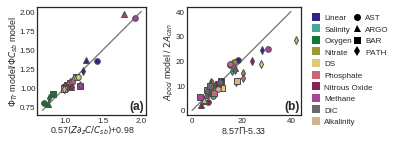

In [10]:
sns.set_style('white')
sns.set_context('paper')

fig,(ax0,ax1) =plt.subplots(1,2,figsize=(5,2))
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']
exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
markers=['o','^','s','d']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]

ax0.plot(np.linspace(0.7,2,20),np.linspace(0.7,2,20),'-',color='0.5')
ax1.plot(np.linspace(0,40,50),
         np.linspace(0,40,50),'-',color='0.5')

for tr_lab,tr, ii, col in zip(labels_tra,tracer_keys, range(len(labels_tra)),colours):
    for file,run,run_phi,lab_exp,can_area,exp,grad,gradtop,Ntop,conc,Hh,Hs,ff,nn,uu,ll,\
    ww,wsb,ss,rr, mark in zip(exp_files,
                             runs,
                             runs_phi,
                             labels_exp,
                             can_Area,                
                             exps,
                             sb_grad,
                             sb_gradtop,
                             N_top,
                             sb_conc,Hhs,Hss,
                             f,N,U,L,
                             Wiso,Wsbs,
                             s,R,
                             markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        slope = (Hs-Hh)/ll
        Cs=conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,ww))
        theta = np.arctan(slope)
        T = ff/((nn**2)*(theta**2))
        Hpool = (ff*uu)/((nn**2)*(theta))
        PhidC = uu*(ZZ**2)*calF*Wsb*grad[ii]
        Cbg = (Hs-Hh)*gradtop[ii] 
        Pi = (calF*(ZZ**2)*grad[ii])/(((Hs-Hh)**2)*gradtop[ii])
       
        file2 = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file2)

        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 to l
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
    
        ax0.plot(slope1*(ZZ*grad[ii]/Cs)+intercept1,PhiTr/(Phi*Cs), marker=mark, markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
       
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax1.plot((slope0*(Pi))+intercept0/(Wsb*ll),
                             np.nanmax(area[ii,:])/(Wsb*ll), 'o', mfc = col, mec='0.3',
                             mew=1, label = tr_lab)
                else:
                    ax1.plot((slope0*(Pi))+intercept0/(Wsb*ll),
                             np.nanmax(area[ii,:])/(Wsb*ll), '^', mfc = col, mec='0.3',
                             mew=1)
            else:
                if lab_exp=='BAR':
                    ax1.plot((slope0*(Pi))+intercept0/(Wsb*ll),
                             np.nanmax(area[ii,:])/(Wsb*ll), 's', mfc = col, mec='0.3',
                             mew=1)
                else:
                    ax1.plot((slope0*(Pi))+intercept0/(Wsb*ll),
                             np.nanmax(area[ii,:])/(Wsb*ll), 'd', mfc = col, mec='0.3',
                             mew=1)
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)

legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(3.3,1.0), handletextpad=0)

legend_elements=[]
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels_tra[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=8),)

ax1.legend(handles=legend_elements, bbox_to_anchor=(1,1), handletextpad=0)
ax1.set_xlabel(r'%1.2f$\Pi$%1.2f' %(slope0,intercept0/(Wsb*ll)), labelpad=0)
ax0.set_xlabel(r'%1.2f$(Z \partial_zC/C_{sb})$+%1.2f' %(slope1,intercept1), labelpad=0)

ax0.set_ylabel('$\Phi_{Tr}$ model/$\Phi C_{sb}$ model', labelpad=0)
ax1.set_ylabel('$A_{pool}$ model / $2A_{can}$', labelpad=0)
ax0.set_aspect(1)
ax1.set_aspect(1)

ax0.text(0.85,0.05,'(a)',fontsize=12, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.85,0.05,'(b)',fontsize=12, fontweight='bold',  transform=ax1.transAxes)

plt.savefig('scaling.eps',format='eps', bbox_inches='tight')

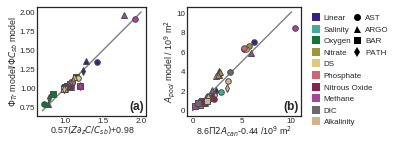

In [11]:
sns.set_style('white')
sns.set_context('paper')

fig,(ax0,ax1) =plt.subplots(1,2,figsize=(5,2))
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']
exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
markers=['o','^','s','d']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]

ax0.plot(np.linspace(0.7,2,20),np.linspace(0.7,2,20),'-',color='0.5')
ax1.plot(np.linspace(0,10.1,50),
         np.linspace(0,10.1,50),'-',color='0.5')

for tr_lab,tr, ii, col in zip(labels_tra,tracer_keys, range(len(labels_tra)),colours):
    for file,run,run_phi,lab_exp,can_area,exp,grad,gradtop,Ntop,conc,Hh,Hs,ff,nn,uu,ll,\
    ww,wsb,ss,rr, mark in zip(exp_files,
                             runs,
                             runs_phi,
                             labels_exp,
                             can_Area,                
                             exps,
                             sb_grad,
                             sb_gradtop,
                             N_top,
                             sb_conc,Hhs,Hss,
                             f,N,U,L,
                             Wiso,Wsbs,
                             s,R,
                             markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        slope = (Hs-Hh)/ll
        Cs=conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,ww))
        theta = np.arctan(slope)
        T = ff/((nn**2)*(theta**2))
        Hpool = (ff*uu)/((nn**2)*(theta))
        PhidC = uu*(ZZ**2)*calF*Wsb*grad[ii]
        Cbg = (Hs-Hh)*gradtop[ii] 
        Pi = (calF*(ZZ**2)*grad[ii])/(((Hs-Hh)**2)*gradtop[ii])
        file2 = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file2)

        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 to l
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
    
        ax0.plot(slope1*(ZZ*grad[ii]/Cs)+intercept1,PhiTr/(Phi*Cs), marker=mark, markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
       
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax1.plot(((slope0*(Pi*Wsb*ll))+intercept0)/1E9,
                             np.nanmax(area[ii,:])/1E9, 'o', mfc = col, mec='0.3',
                             mew=1, label = tr_lab)
                else:
                    ax1.plot(((slope0*(Pi*Wsb*ll))+intercept0)/1E9,
                             np.nanmax(area[ii,:])/1E9, '^', mfc = col, mec='0.3',
                             mew=1)
            else:
                if lab_exp=='BAR':
                    ax1.plot(((slope0*(Pi*Wsb*ll))+intercept0)/1E9,
                             np.nanmax(area[ii,:])/1E9, 's', mfc = col, mec='0.3',
                             mew=1)
                else:
                    ax1.plot(((slope0*(Pi*Wsb*ll))+intercept0)/1E9,
                             np.nanmax(area[ii,:])/1E9, 'd', mfc = col, mec='0.3',
                             mew=1)
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)

legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(3.3,1.0), handletextpad=0)

legend_elements=[]
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels_tra[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=8),)

ax1.legend(handles=legend_elements, bbox_to_anchor=(1,1), handletextpad=0)
ax1.set_xlabel(r'%1.1f$\Pi 2A_{can}$%1.2f /10$^{9}$ m$^2$' %(slope0,intercept0/1E9), labelpad=0)
ax0.set_xlabel(r'%1.2f$(Z \partial_zC/C_{sb})$+%1.2f' %(slope1,intercept1), labelpad=0)

ax0.set_ylabel('$\Phi_{Tr}$ model/$\Phi C_{sb}$ model', labelpad=0)
ax1.set_ylabel('$A_{pool}$ model / 10$^{9}$ m$^2$', labelpad=0)
ax0.set_aspect(1)
ax1.set_aspect(1)

ax0.text(0.85,0.05,'(a)',fontsize=12, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.85,0.05,'(b)',fontsize=12, fontweight='bold',  transform=ax1.transAxes)

plt.savefig('scaling_dimPool.eps',format='eps', bbox_inches='tight')